# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 18.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-5-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

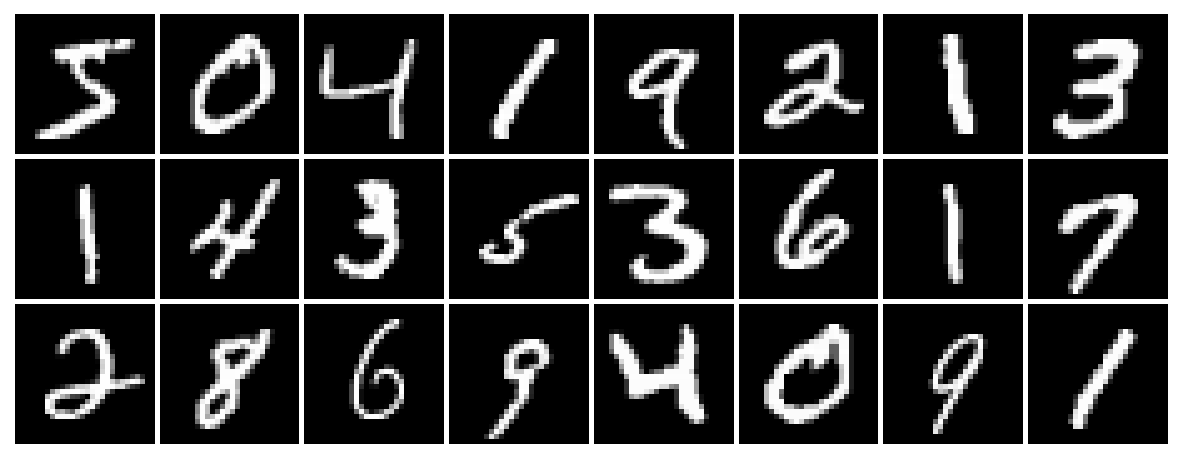

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


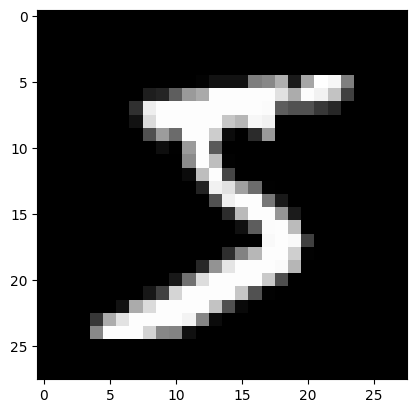

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 1.4313e-01, -2.3782e-01,  3.6080e-01,  1.3542e-01,  6.7864e-02,
         -2.4052e-02, -2.5613e-01,  5.8199e-02, -9.0937e-03, -5.1218e-01],
        [ 4.0971e-01, -1.7990e-01,  3.3791e-01,  2.2009e-01,  1.1244e-01,
         -2.0921e-01,  1.3426e-01,  1.5786e-01,  5.0314e-01, -2.7153e-01],
        [ 8.0151e-02, -2.6948e-01,  2.0998e-01, -1.4210e-01, -3.1741e-02,
          3.0891e-02, -1.7634e-01, -2.2984e-04,  3.1887e-02, -6.8062e-02],
        [ 1.7298e-01, -1.2227e-01, -1.2089e-01, -5.0822e-02,  2.3971e-02,
          2.7026e-01,  1.7744e-02, -7.8285e-02, -1.2183e-01, -5.9426e-02],
        [ 1.9884e-01, -1.0109e-01,  2.0088e-01,  3.4933e-02, -1.7414e-01,
          1.4940e-01, -1.2759e-01, -7.1599e-03, -2.8924e-02, -1.7901e-01]],
       grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [12]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-q9dclmpa
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-q9dclmpa
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=2d928c6e323cf9fc1bf35f26dabfd2d0dc410beeaa76ea461970287b835da00a
  Stored in directory: /tmp/pip-ephem-wheel-cache-2e_buipv/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3437, grad_fn=<NllLossBackward0>)

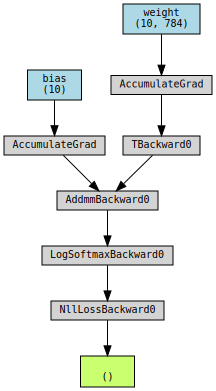

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

epoch: [1:100]  |  loss: 0.17811135947704315  |  accuracy: 0.967


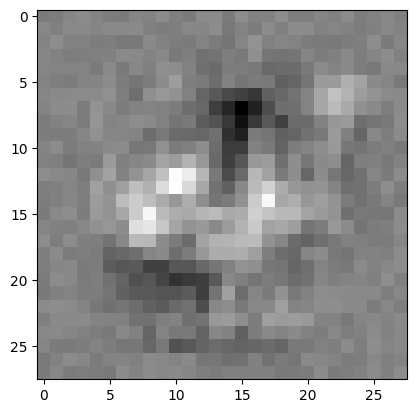

epoch: [2:100]  |  loss: 0.17753662168979645  |  accuracy: 0.967


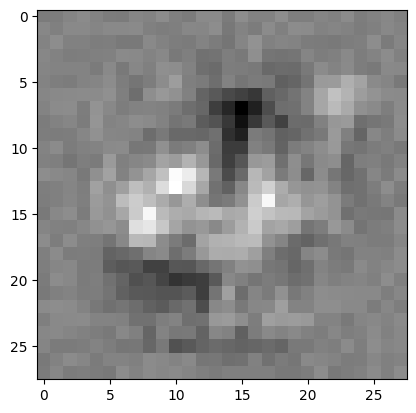

epoch: [3:100]  |  loss: 0.17696546018123627  |  accuracy: 0.967


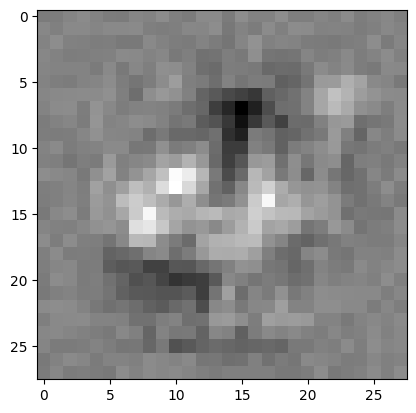

epoch: [4:100]  |  loss: 0.17639781534671783  |  accuracy: 0.967


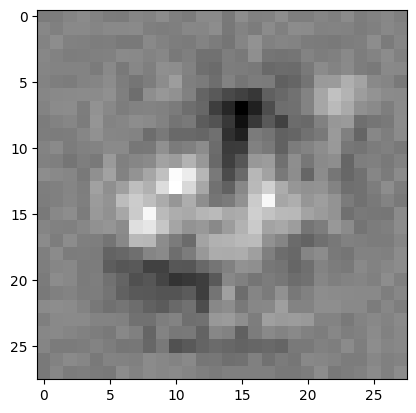

epoch: [5:100]  |  loss: 0.17583364248275757  |  accuracy: 0.967


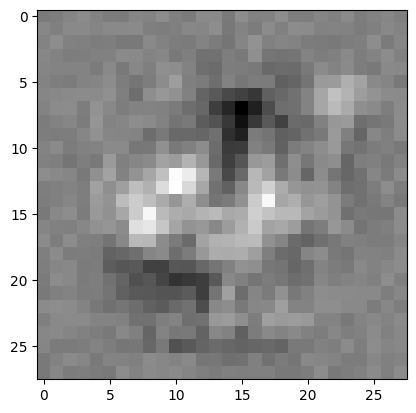

epoch: [6:100]  |  loss: 0.17527295649051666  |  accuracy: 0.967


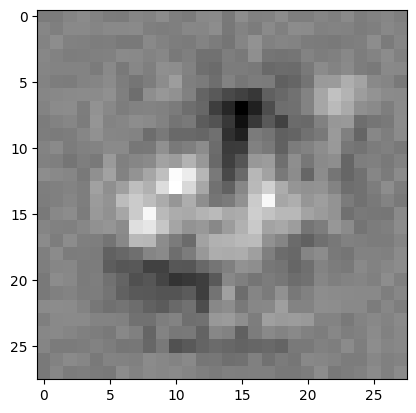

epoch: [7:100]  |  loss: 0.17471565306186676  |  accuracy: 0.967


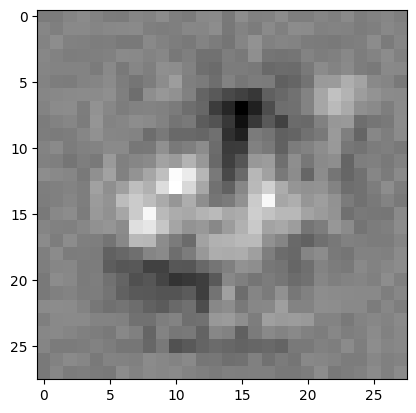

epoch: [8:100]  |  loss: 0.17416173219680786  |  accuracy: 0.967


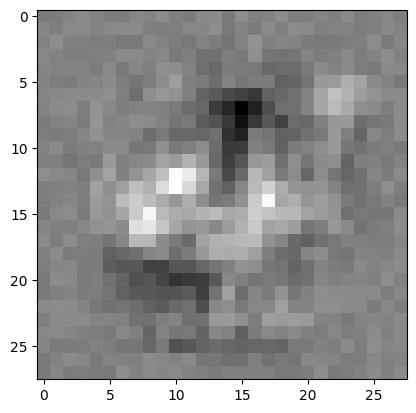

epoch: [9:100]  |  loss: 0.17361117899417877  |  accuracy: 0.967


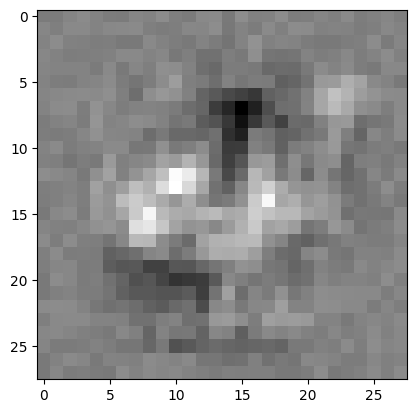

epoch: [10:100]  |  loss: 0.17306390404701233  |  accuracy: 0.967


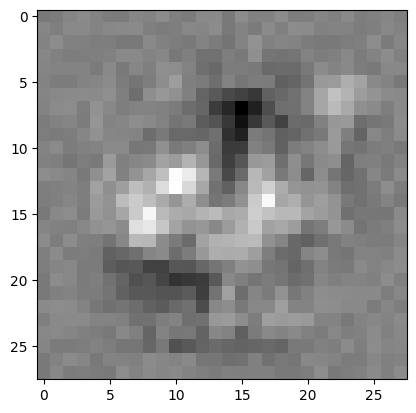

epoch: [11:100]  |  loss: 0.17251993715763092  |  accuracy: 0.967


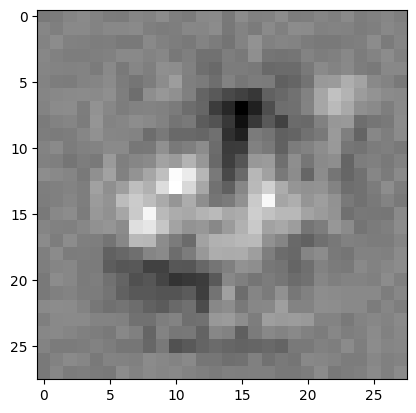

epoch: [12:100]  |  loss: 0.17197923362255096  |  accuracy: 0.967


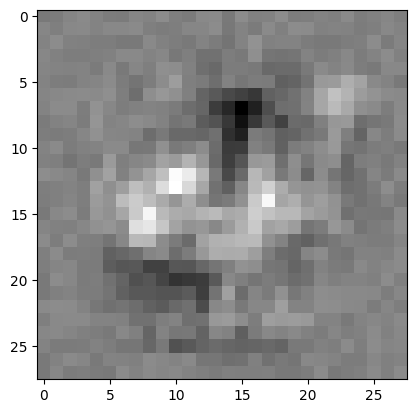

epoch: [13:100]  |  loss: 0.1714417040348053  |  accuracy: 0.967


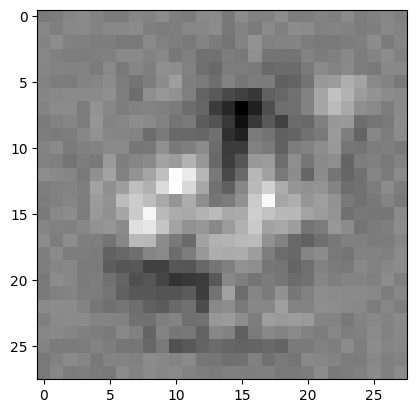

epoch: [14:100]  |  loss: 0.1709073930978775  |  accuracy: 0.967


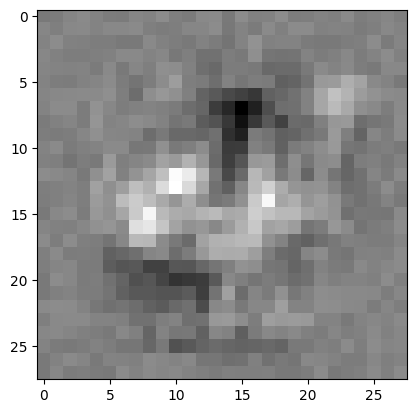

epoch: [15:100]  |  loss: 0.17037621140480042  |  accuracy: 0.967


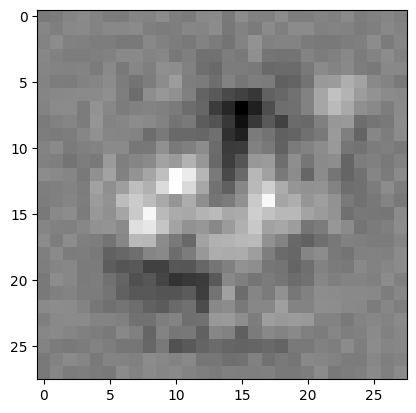

epoch: [16:100]  |  loss: 0.16984815895557404  |  accuracy: 0.967


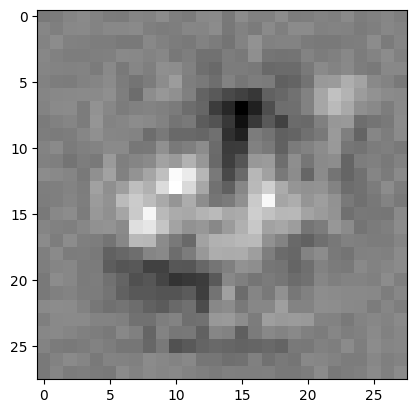

epoch: [17:100]  |  loss: 0.16932320594787598  |  accuracy: 0.967


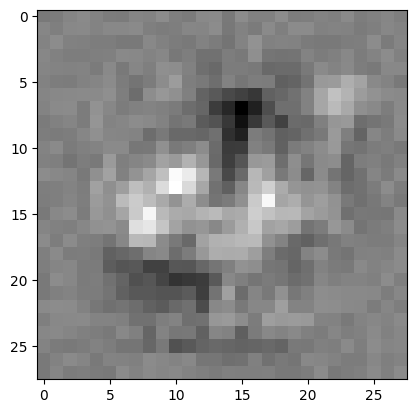

epoch: [18:100]  |  loss: 0.16880132257938385  |  accuracy: 0.967


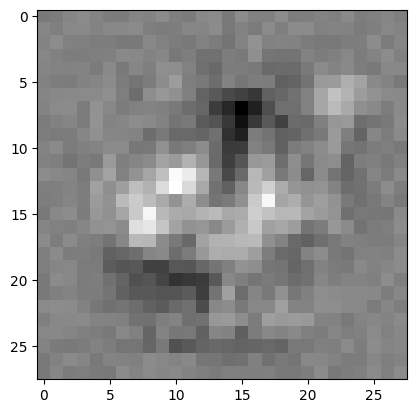

epoch: [19:100]  |  loss: 0.16828244924545288  |  accuracy: 0.967


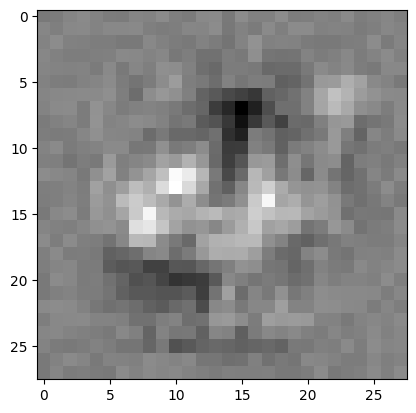

epoch: [20:100]  |  loss: 0.16776657104492188  |  accuracy: 0.967


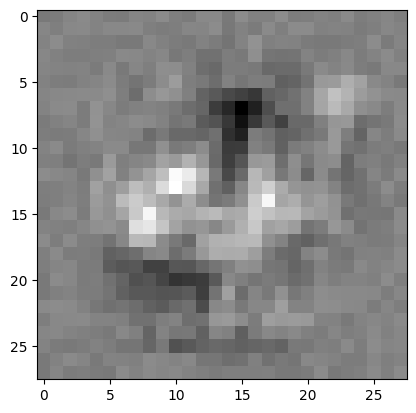

epoch: [21:100]  |  loss: 0.16725368797779083  |  accuracy: 0.967


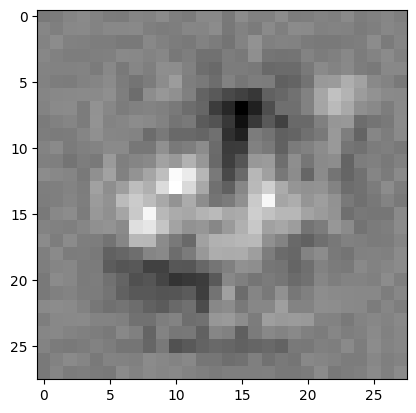

epoch: [22:100]  |  loss: 0.16674375534057617  |  accuracy: 0.967


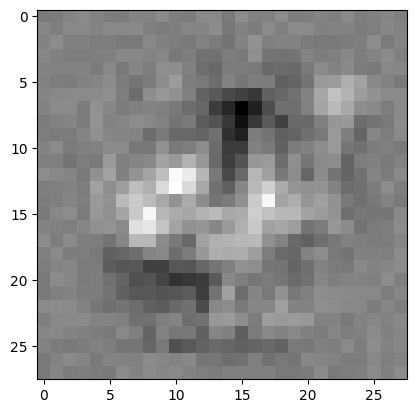

epoch: [23:100]  |  loss: 0.1662367582321167  |  accuracy: 0.967


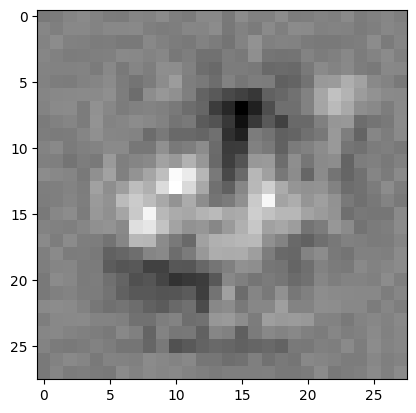

epoch: [24:100]  |  loss: 0.16573262214660645  |  accuracy: 0.967


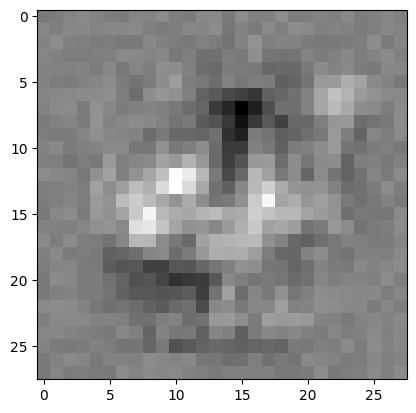

epoch: [25:100]  |  loss: 0.1652313768863678  |  accuracy: 0.967


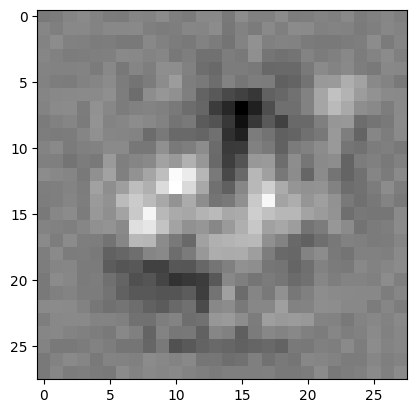

epoch: [26:100]  |  loss: 0.16473297774791718  |  accuracy: 0.967


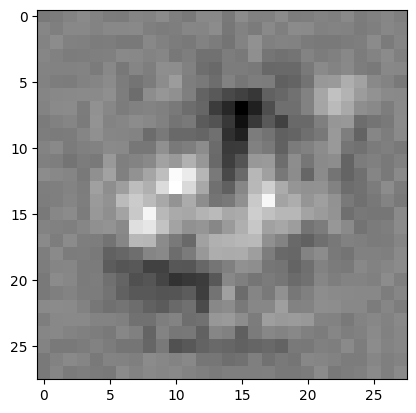

epoch: [27:100]  |  loss: 0.1642373651266098  |  accuracy: 0.967


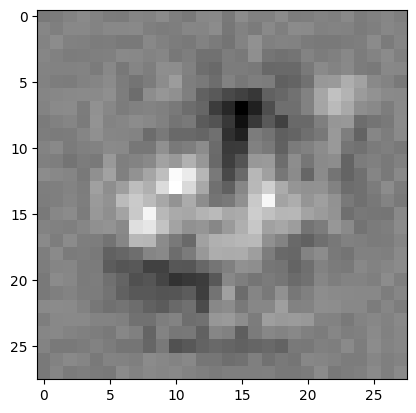

epoch: [28:100]  |  loss: 0.16374453902244568  |  accuracy: 0.967


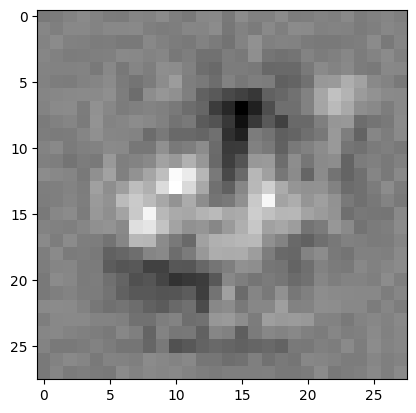

epoch: [29:100]  |  loss: 0.1632544994354248  |  accuracy: 0.967


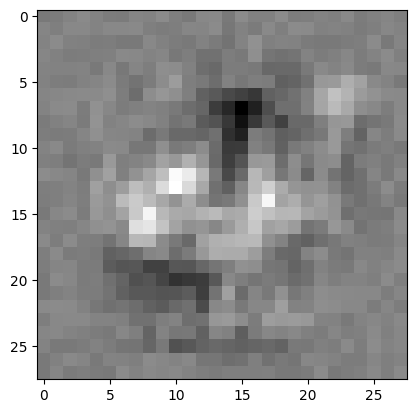

epoch: [30:100]  |  loss: 0.1627671867609024  |  accuracy: 0.968


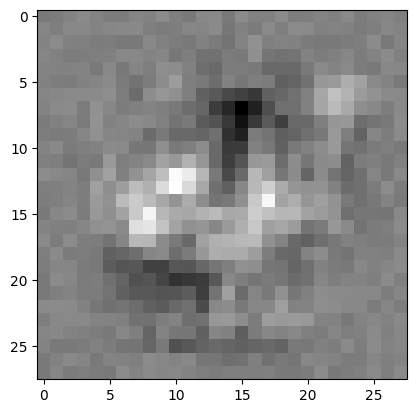

epoch: [31:100]  |  loss: 0.1622825264930725  |  accuracy: 0.968


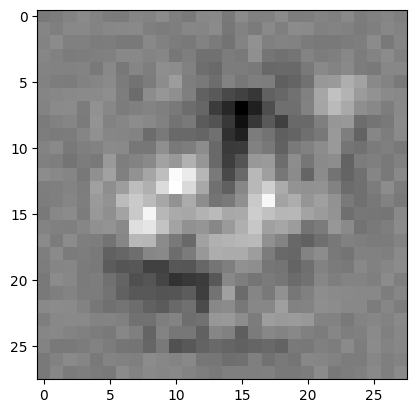

epoch: [32:100]  |  loss: 0.16180062294006348  |  accuracy: 0.968


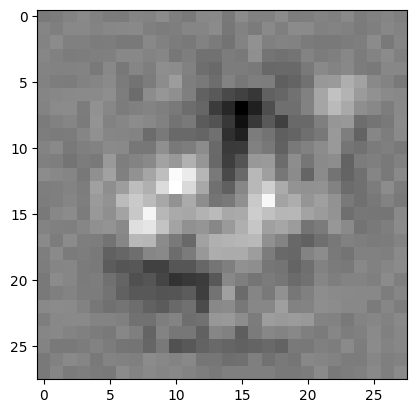

epoch: [33:100]  |  loss: 0.16132138669490814  |  accuracy: 0.968


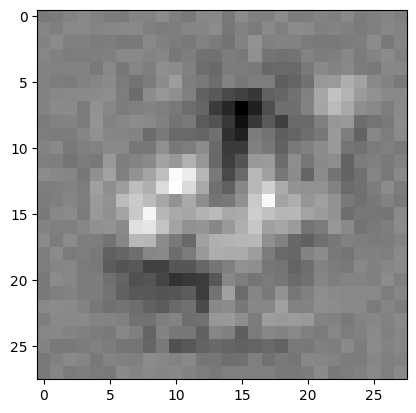

epoch: [34:100]  |  loss: 0.16084475815296173  |  accuracy: 0.968


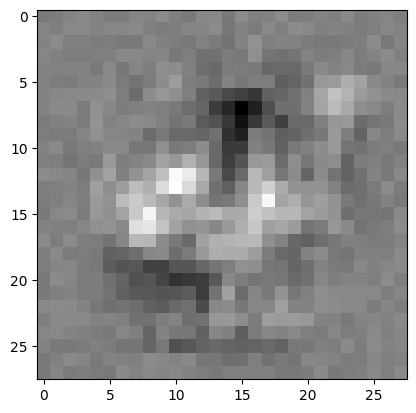

epoch: [35:100]  |  loss: 0.16037076711654663  |  accuracy: 0.968


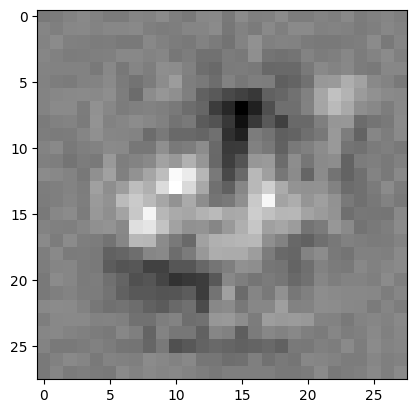

epoch: [36:100]  |  loss: 0.15989933907985687  |  accuracy: 0.968


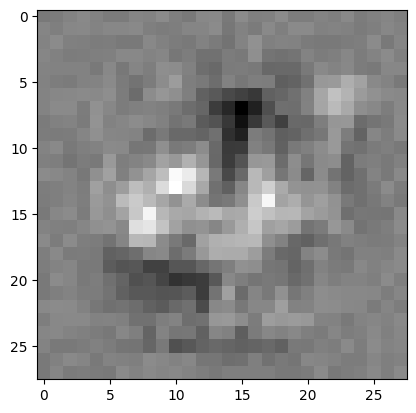

epoch: [37:100]  |  loss: 0.15943051874637604  |  accuracy: 0.969


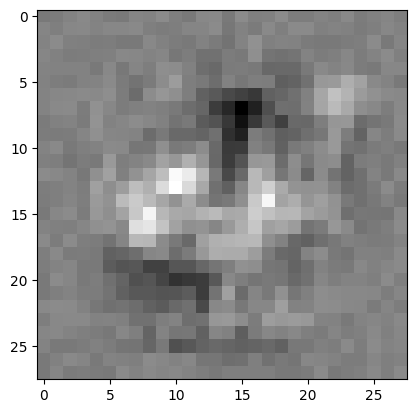

epoch: [38:100]  |  loss: 0.15896424651145935  |  accuracy: 0.97


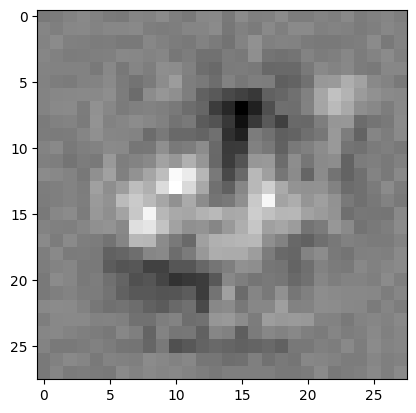

epoch: [39:100]  |  loss: 0.15850047767162323  |  accuracy: 0.97


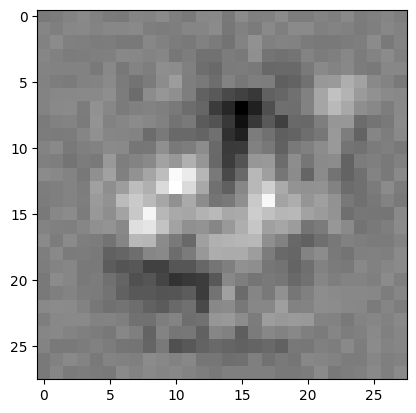

epoch: [40:100]  |  loss: 0.15803919732570648  |  accuracy: 0.972


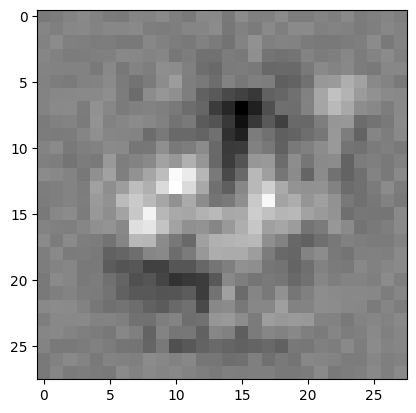

epoch: [41:100]  |  loss: 0.1575804501771927  |  accuracy: 0.972


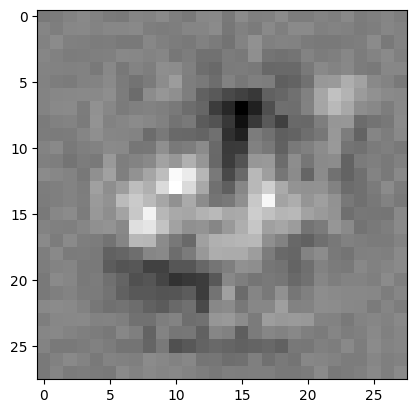

epoch: [42:100]  |  loss: 0.1571241319179535  |  accuracy: 0.972


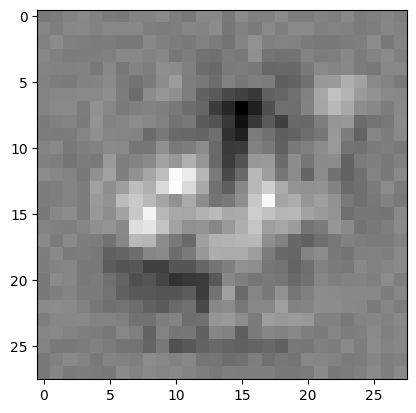

epoch: [43:100]  |  loss: 0.15667025744915009  |  accuracy: 0.972


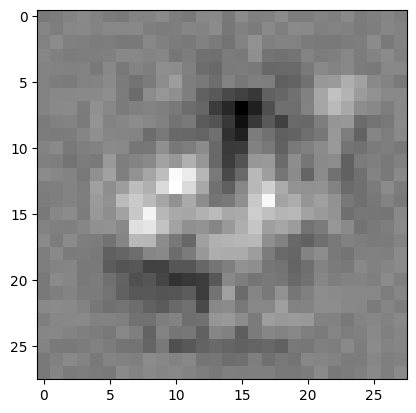

epoch: [44:100]  |  loss: 0.15621881186962128  |  accuracy: 0.973


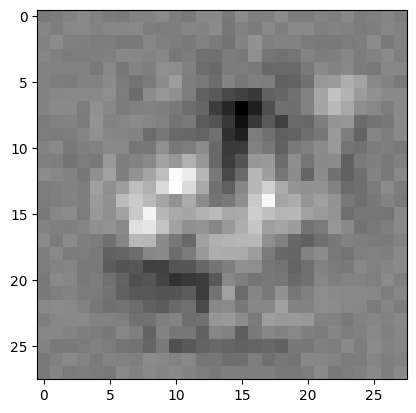

epoch: [45:100]  |  loss: 0.15576975047588348  |  accuracy: 0.974


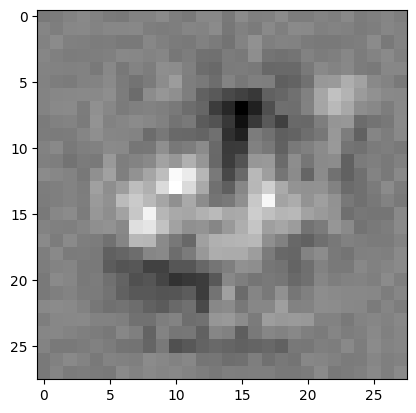

epoch: [46:100]  |  loss: 0.15532304346561432  |  accuracy: 0.974


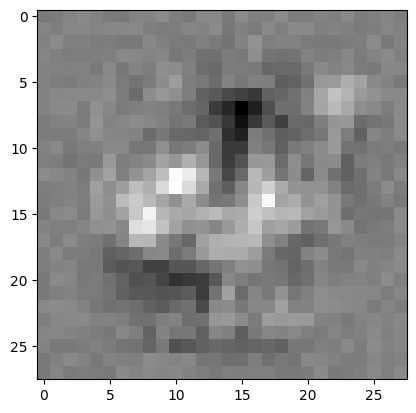

epoch: [47:100]  |  loss: 0.15487873554229736  |  accuracy: 0.974


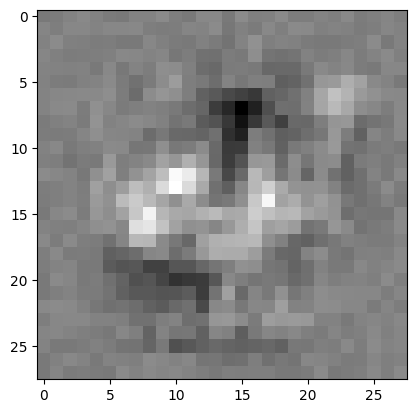

epoch: [48:100]  |  loss: 0.15443675220012665  |  accuracy: 0.974


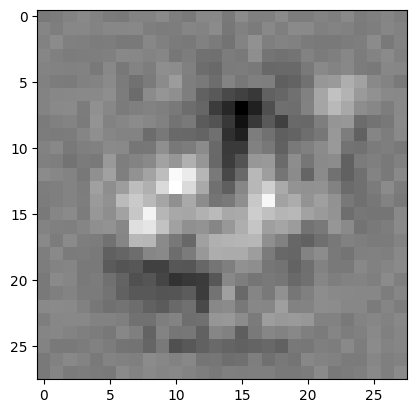

epoch: [49:100]  |  loss: 0.15399707853794098  |  accuracy: 0.974


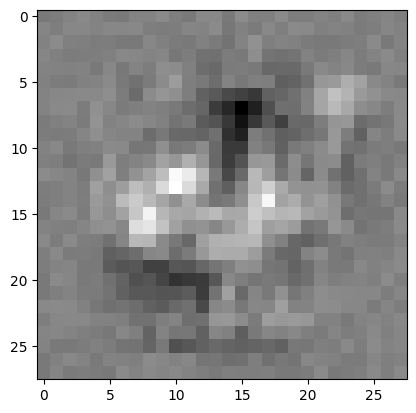

epoch: [50:100]  |  loss: 0.15355974435806274  |  accuracy: 0.975


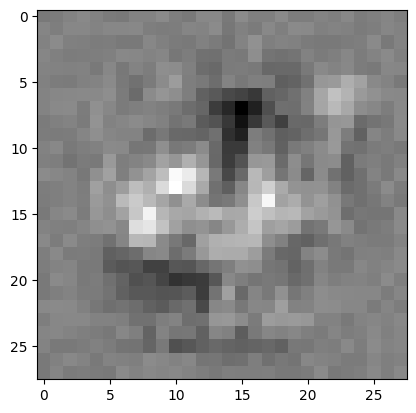

epoch: [51:100]  |  loss: 0.1531246453523636  |  accuracy: 0.975


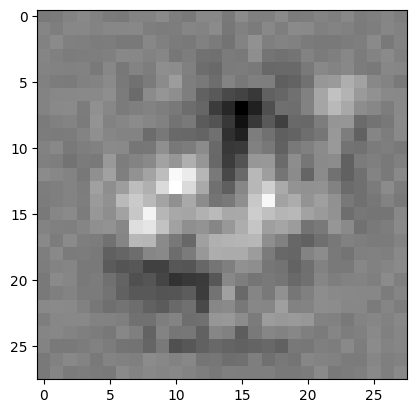

epoch: [52:100]  |  loss: 0.1526918262243271  |  accuracy: 0.975


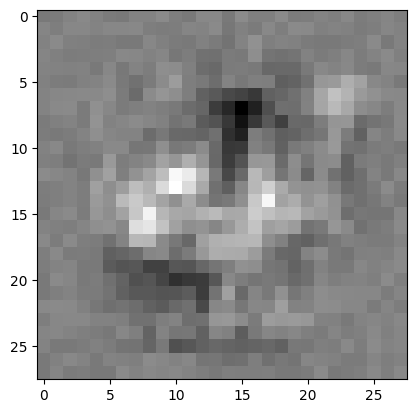

epoch: [53:100]  |  loss: 0.15226127207279205  |  accuracy: 0.975


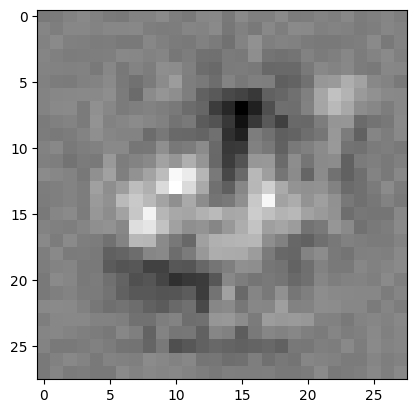

epoch: [54:100]  |  loss: 0.1518329232931137  |  accuracy: 0.975


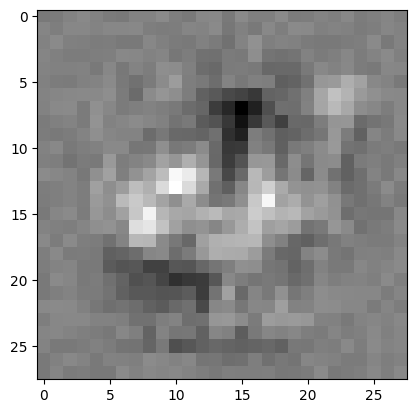

epoch: [55:100]  |  loss: 0.15140676498413086  |  accuracy: 0.975


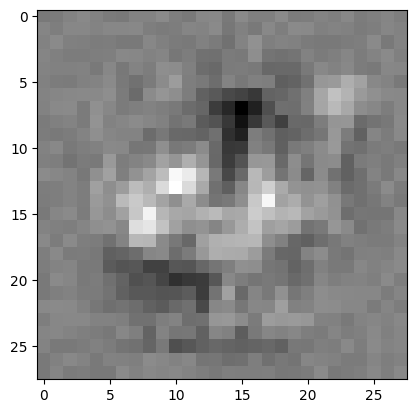

epoch: [56:100]  |  loss: 0.1509828120470047  |  accuracy: 0.975


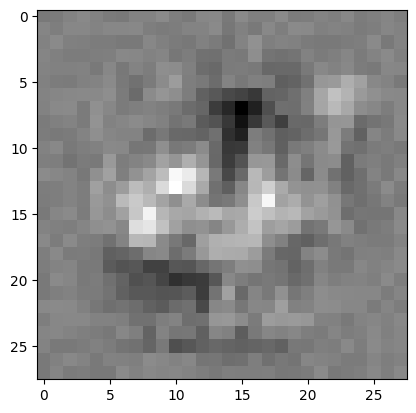

epoch: [57:100]  |  loss: 0.15056103467941284  |  accuracy: 0.975


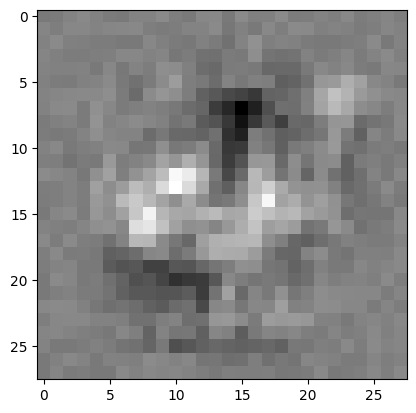

epoch: [58:100]  |  loss: 0.1501414179801941  |  accuracy: 0.975


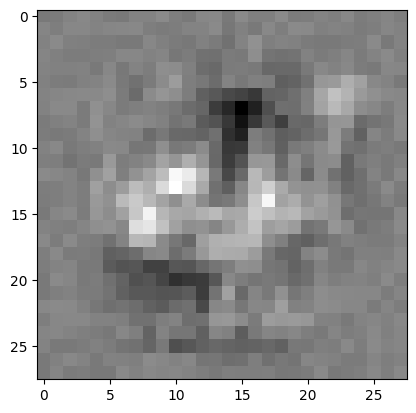

epoch: [59:100]  |  loss: 0.14972394704818726  |  accuracy: 0.975


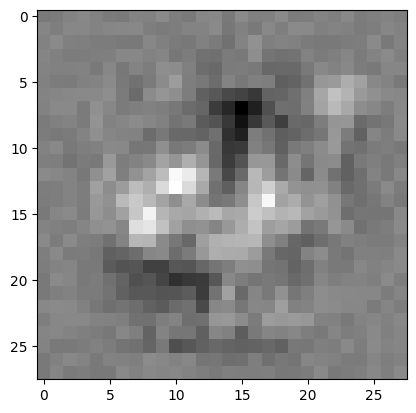

epoch: [60:100]  |  loss: 0.14930857717990875  |  accuracy: 0.975


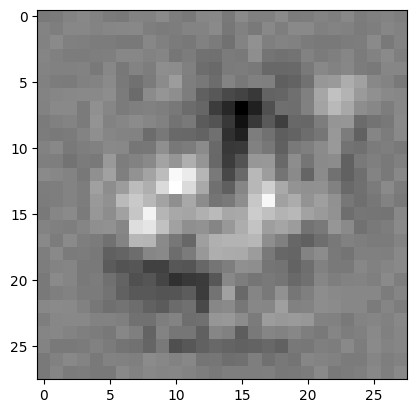

epoch: [61:100]  |  loss: 0.14889530837535858  |  accuracy: 0.975


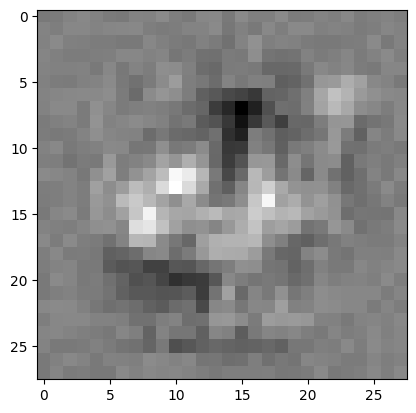

epoch: [62:100]  |  loss: 0.14848414063453674  |  accuracy: 0.975


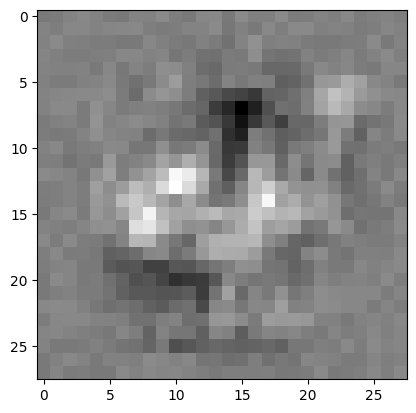

epoch: [63:100]  |  loss: 0.14807504415512085  |  accuracy: 0.975


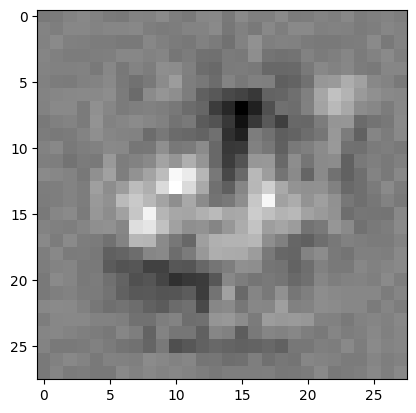

epoch: [64:100]  |  loss: 0.14766797423362732  |  accuracy: 0.975


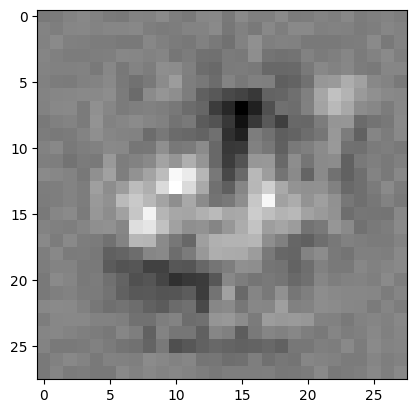

epoch: [65:100]  |  loss: 0.14726297557353973  |  accuracy: 0.975


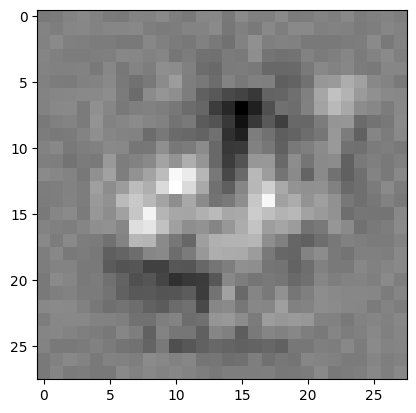

epoch: [66:100]  |  loss: 0.14685997366905212  |  accuracy: 0.975


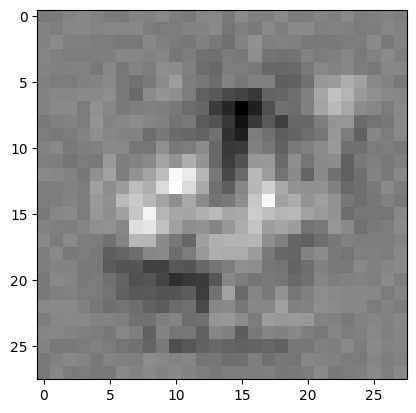

epoch: [67:100]  |  loss: 0.14645901322364807  |  accuracy: 0.975


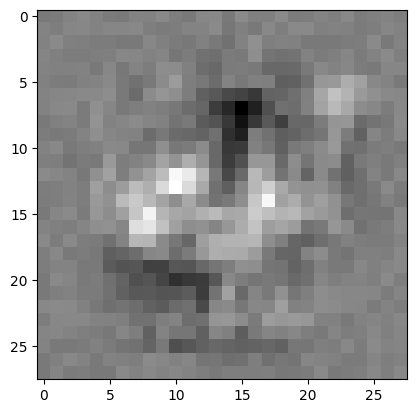

epoch: [68:100]  |  loss: 0.146060049533844  |  accuracy: 0.975


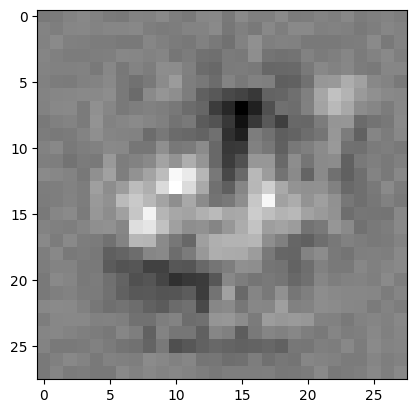

epoch: [69:100]  |  loss: 0.14566302299499512  |  accuracy: 0.975


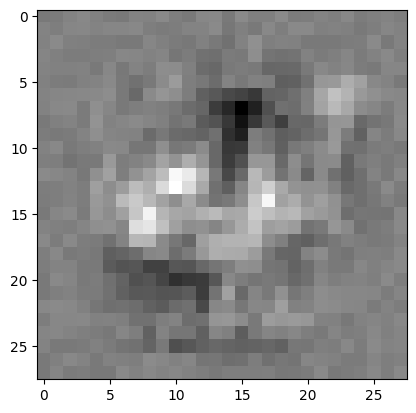

epoch: [70:100]  |  loss: 0.14526797831058502  |  accuracy: 0.975


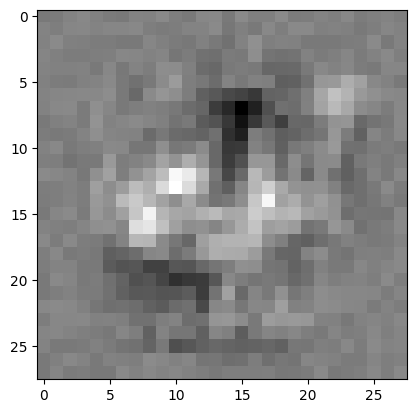

epoch: [71:100]  |  loss: 0.14487490057945251  |  accuracy: 0.975


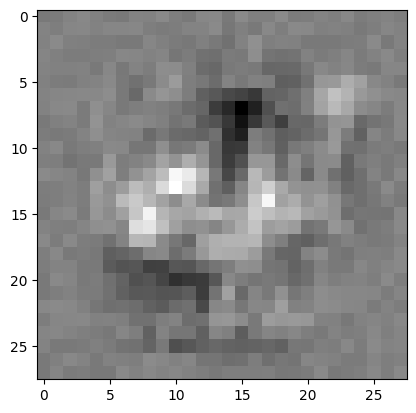

epoch: [72:100]  |  loss: 0.14448371529579163  |  accuracy: 0.975


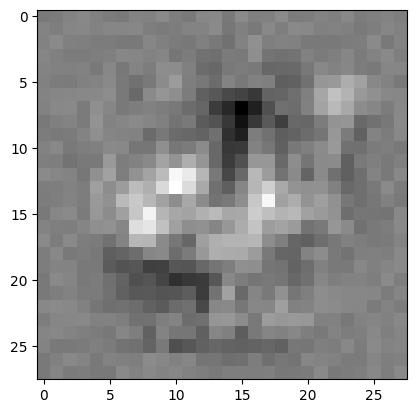

epoch: [73:100]  |  loss: 0.14409445226192474  |  accuracy: 0.975


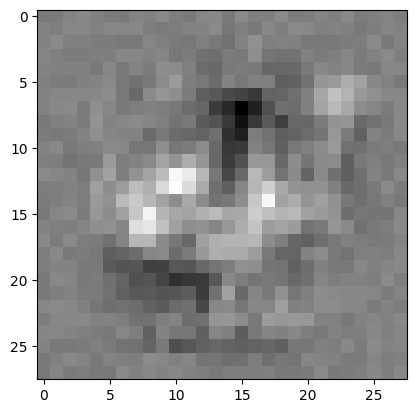

epoch: [74:100]  |  loss: 0.14370711147785187  |  accuracy: 0.975


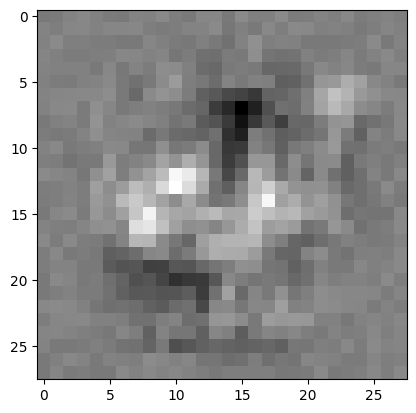

epoch: [75:100]  |  loss: 0.14332164824008942  |  accuracy: 0.975


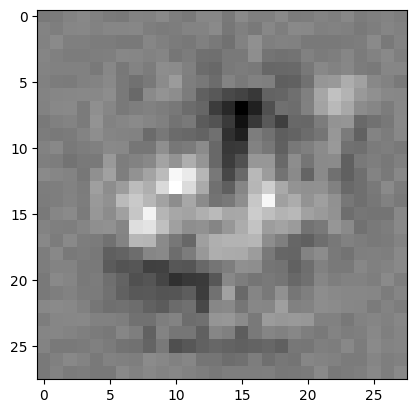

epoch: [76:100]  |  loss: 0.14293807744979858  |  accuracy: 0.975


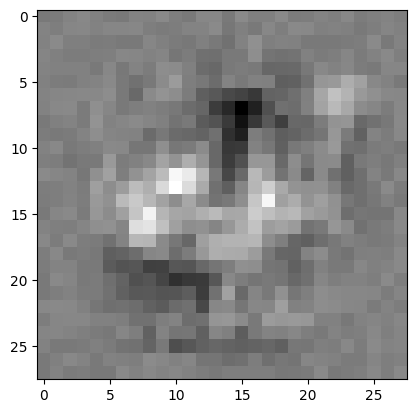

epoch: [77:100]  |  loss: 0.1425563544034958  |  accuracy: 0.975


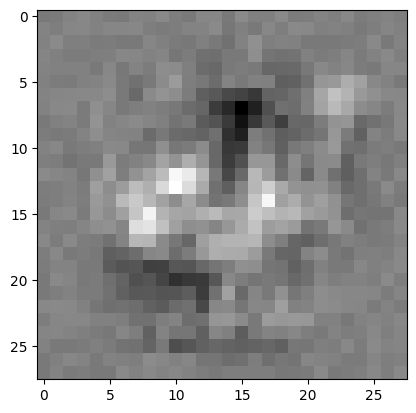

epoch: [78:100]  |  loss: 0.14217649400234222  |  accuracy: 0.975


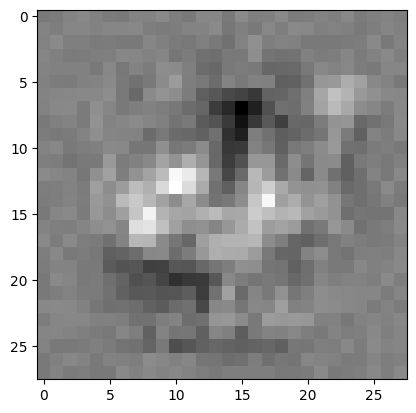

epoch: [79:100]  |  loss: 0.1417984515428543  |  accuracy: 0.975


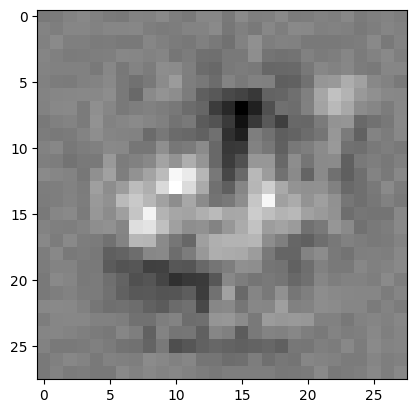

epoch: [80:100]  |  loss: 0.14142224192619324  |  accuracy: 0.975


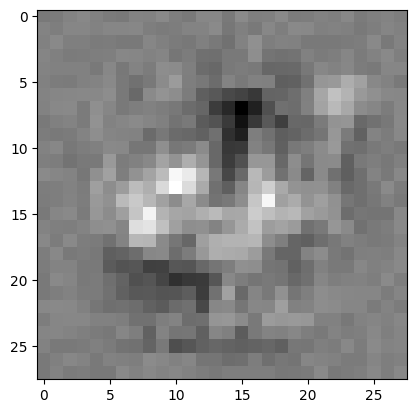

epoch: [81:100]  |  loss: 0.14104785025119781  |  accuracy: 0.975


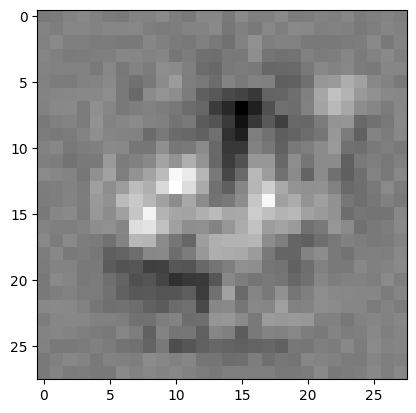

epoch: [82:100]  |  loss: 0.14067520201206207  |  accuracy: 0.975


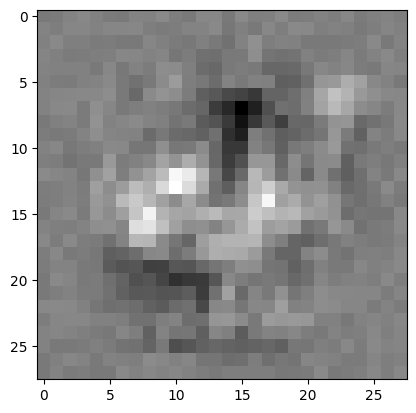

epoch: [83:100]  |  loss: 0.14030437171459198  |  accuracy: 0.975


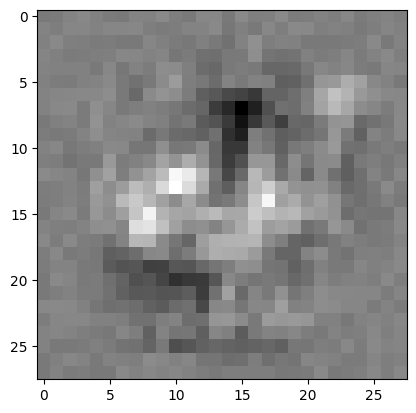

epoch: [84:100]  |  loss: 0.13993531465530396  |  accuracy: 0.975


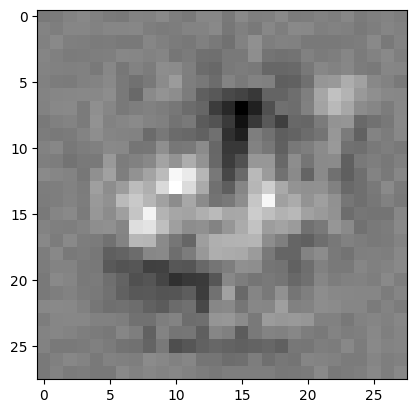

epoch: [85:100]  |  loss: 0.13956798613071442  |  accuracy: 0.976


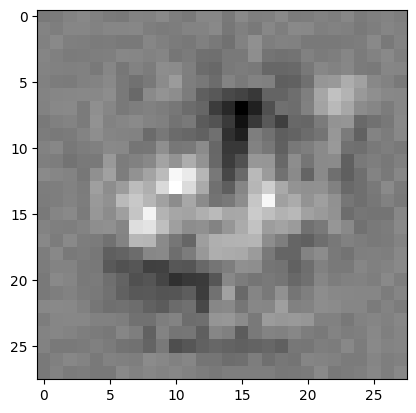

epoch: [86:100]  |  loss: 0.13920246064662933  |  accuracy: 0.976


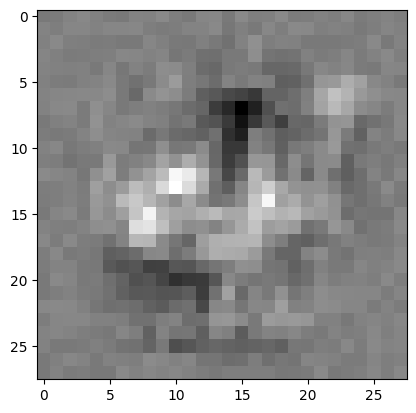

epoch: [87:100]  |  loss: 0.13883860409259796  |  accuracy: 0.976


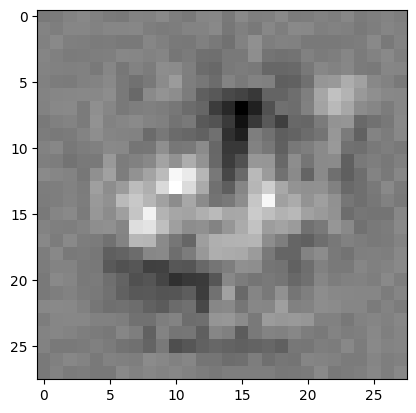

epoch: [88:100]  |  loss: 0.13847649097442627  |  accuracy: 0.976


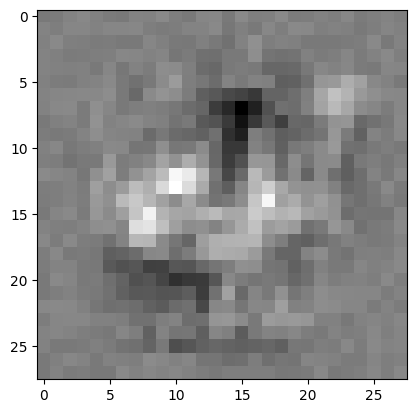

epoch: [89:100]  |  loss: 0.13811607658863068  |  accuracy: 0.976


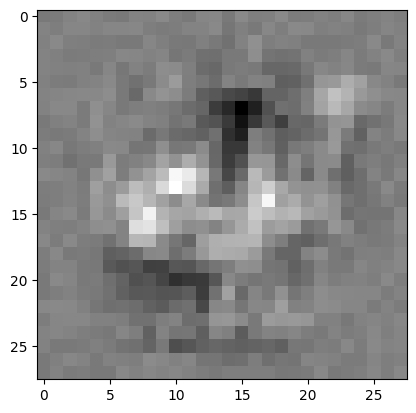

epoch: [90:100]  |  loss: 0.13775737583637238  |  accuracy: 0.976


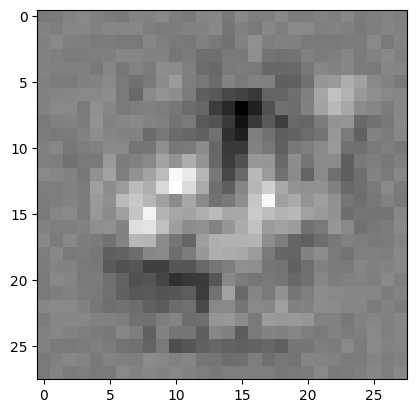

epoch: [91:100]  |  loss: 0.1374003291130066  |  accuracy: 0.976


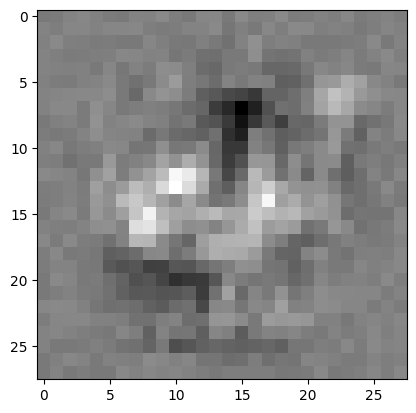

epoch: [92:100]  |  loss: 0.1370449662208557  |  accuracy: 0.976


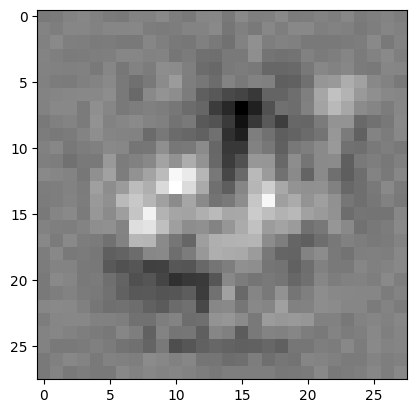

epoch: [93:100]  |  loss: 0.13669125735759735  |  accuracy: 0.976


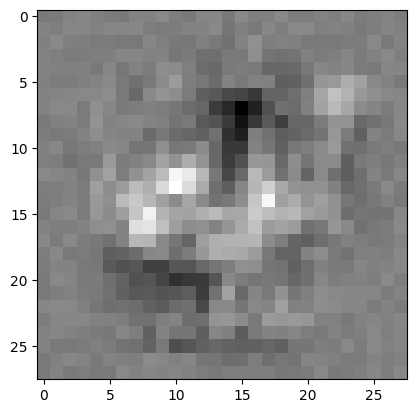

epoch: [94:100]  |  loss: 0.1363392174243927  |  accuracy: 0.976


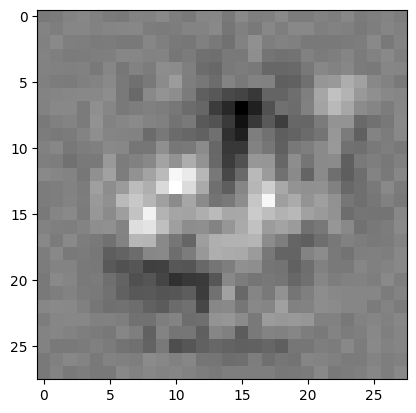

epoch: [95:100]  |  loss: 0.13598880171775818  |  accuracy: 0.976


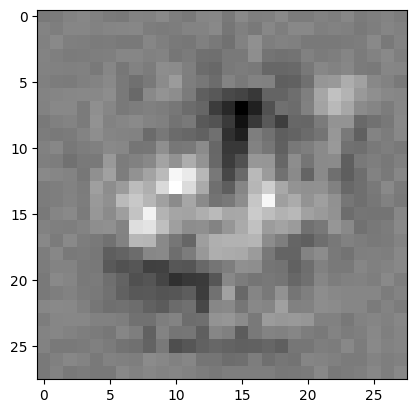

epoch: [96:100]  |  loss: 0.1356399953365326  |  accuracy: 0.976


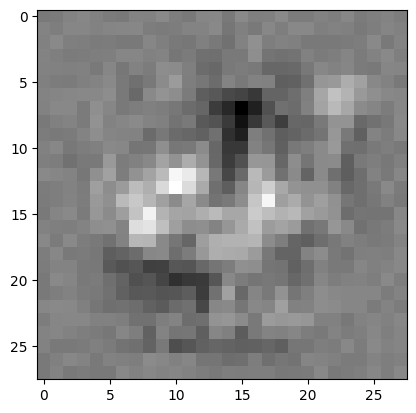

epoch: [97:100]  |  loss: 0.13529281318187714  |  accuracy: 0.976


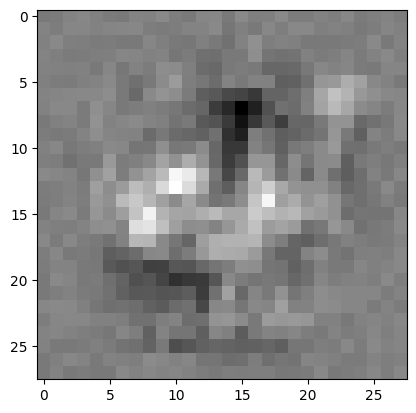

epoch: [98:100]  |  loss: 0.13494724035263062  |  accuracy: 0.978


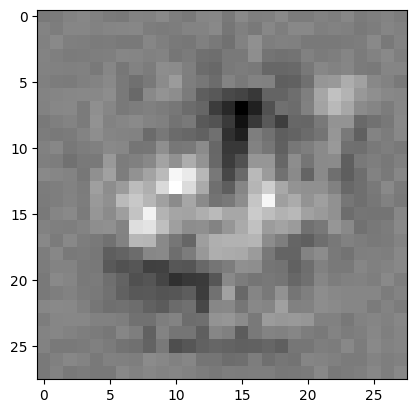

epoch: [99:100]  |  loss: 0.13460326194763184  |  accuracy: 0.978


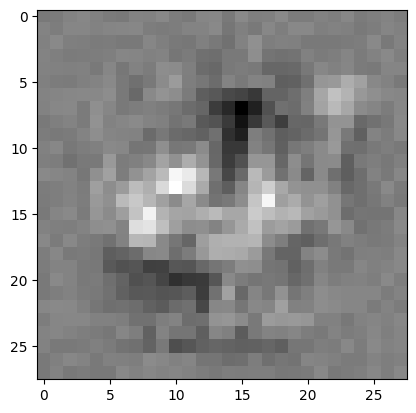

epoch: [100:100]  |  loss: 0.13426083326339722  |  accuracy: 0.978


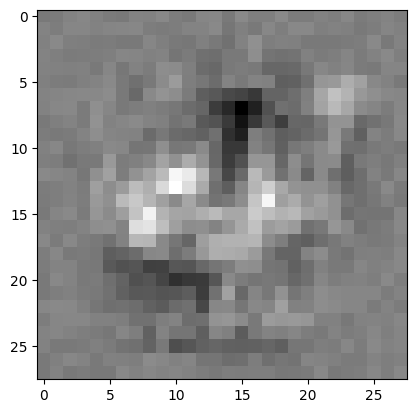

In [23]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    weights = model.state_dict()['weight']

    print(f'epoch: [{i+1}:{epochs}]  |  loss: {loss}  |  accuracy: {accuracy}')
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()


In [16]:
print('Final loss:', loss.item())

Final loss: 0.2656089663505554


### Visualizando gráfico de perda durante o treinamento

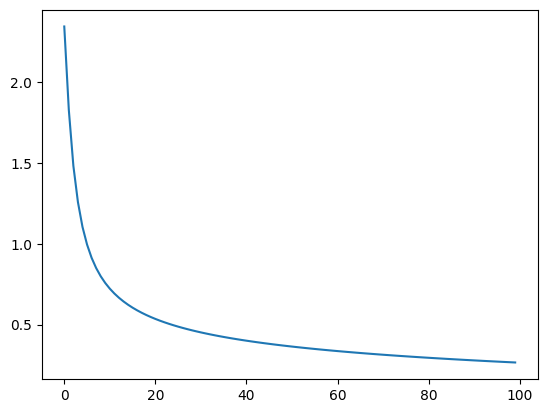

In [17]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.943


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,1,1,1,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,83,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


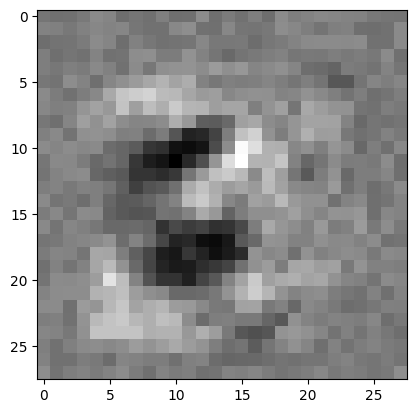

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

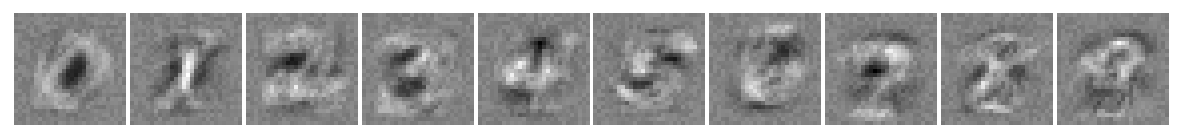

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

# Aprendizados
